In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer 

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve


In [2]:
features_df = pd.read_csv('../Data/training_set_features.csv')
labels_df = pd.read_csv('../Data/training_set_labels.csv')

# check that the rows between the features and the labels match up
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

# merge features_df and labels_df 
df = labels_df.merge(features_df, how = 'inner', on='respondent_id')

# drop duplicate 
df.drop_duplicates(inplace=True)

In [3]:
df.shape

(26707, 38)

In [4]:
df.info()

# 17  health_insurance, 36  employment_industry, 37  employment_occupation  about 50% missing 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_vaccine                 26707 non-null  int64  
 2   seasonal_vaccine             26707 non-null  int64  
 3   h1n1_concern                 26615 non-null  float64
 4   h1n1_knowledge               26591 non-null  float64
 5   behavioral_antiviral_meds    26636 non-null  float64
 6   behavioral_avoidance         26499 non-null  float64
 7   behavioral_face_mask         26688 non-null  float64
 8   behavioral_wash_hands        26665 non-null  float64
 9   behavioral_large_gatherings  26620 non-null  float64
 10  behavioral_outside_home      26625 non-null  float64
 11  behavioral_touch_face        26579 non-null  float64
 12  doctor_recc_h1n1             24547 non-null  float64
 13  doctor_recc_seas

In [5]:
# All features are categorical variables 
#df.describe().T

In [6]:
# Check balance of target variables 

print("H1N1 Vaccination (counts)")
print(df["h1n1_vaccine"].value_counts())
print()
print("Seasonal Flu Vaccination (counts)")
print(df["seasonal_vaccine"].value_counts())
print()
print("H1N1 Vaccination (percentages)")
print(df["h1n1_vaccine"].value_counts(normalize=True))
print()
print("Seasonal Flu Vaccination (percentages)")
print(df["seasonal_vaccine"].value_counts(normalize=True))

# Only 21% of people are vaccinated. H1N1 vaccination data is highly imbalanced. 
# For model tuning, use SMOTE or other methods.  



H1N1 Vaccination (counts)
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

Seasonal Flu Vaccination (counts)
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

H1N1 Vaccination (percentages)
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

Seasonal Flu Vaccination (percentages)
0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64


In [7]:
# 4697 received both shots, and 13295 (about half) received zero. 

df.groupby(['h1n1_vaccine','seasonal_vaccine'])['respondent_id'].count()



h1n1_vaccine  seasonal_vaccine
0             0                   13295
              1                    7738
1             0                     977
              1                    4697
Name: respondent_id, dtype: int64

In [8]:
# High risk group dummy 

# high_risk = 1 if a person is a healthworker, has chronic medical conditions, or live with infants.

#df['high_risk'] = ((df["chronic_med_condition"]==1)|(df['child_under_6_months']==1) | (df['health_worker']==1)).astype(int)


In [9]:
df.income_poverty.value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [10]:
# poverty dummy

#df['poverty']= (df['income_poverty']=='Below Poverty').astype(int)


### EDA 

In [11]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (df.groupby([target, col])
                  .size()
                  .unstack(target)
             )
    props = counts.div(counts.sum(axis='columns'), axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()
    



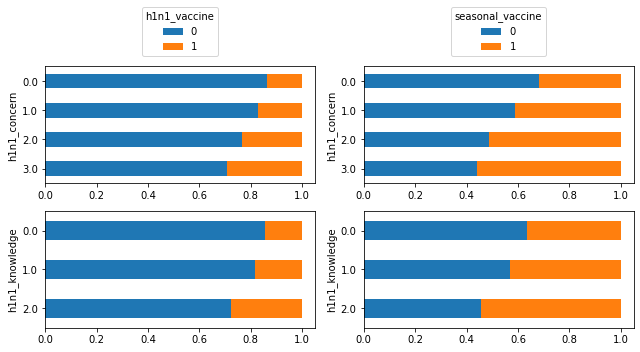

In [12]:
# Feature - Concerns, Knowledge 
concerns = ['h1n1_concern','h1n1_knowledge']


cols_to_plot=concerns

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout(); 

# higher concern and larger knowledge, more vaccinated. 

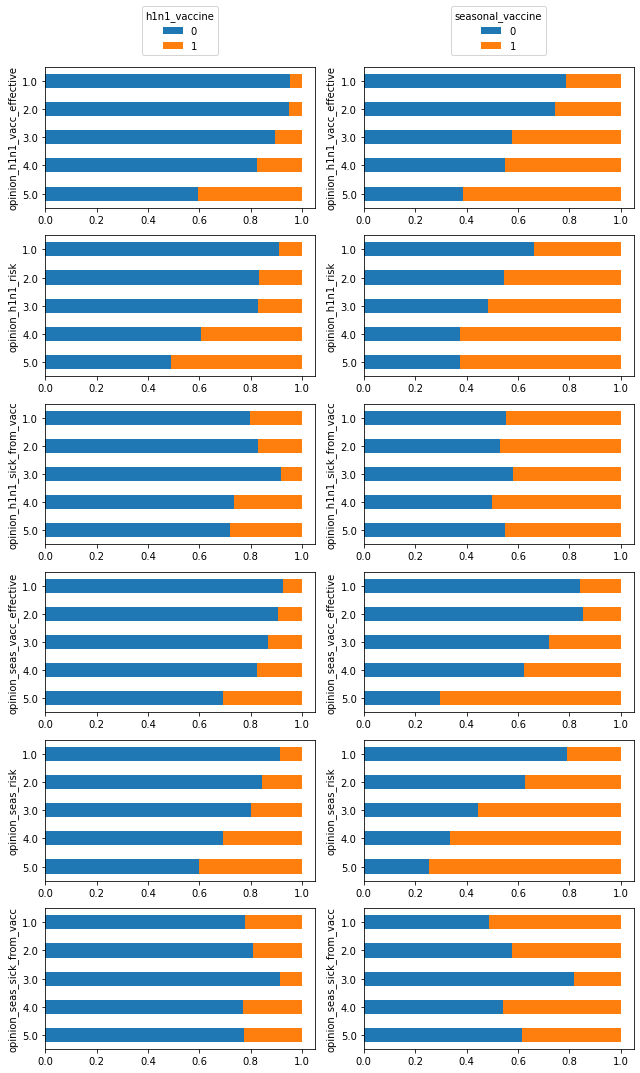

In [13]:
# Features - Opinions
opinions=['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 
          'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc' ]

cols_to_plot=opinions

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout();

# 1 Respondent's opinion about H1N1 vaccine effectiveness. 
##  More vaccinated, more answers of 5 = Very effective 
# 2 Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
##  More vaccinated, ore answeres 4 = Somewhat high , 5 = Very effective; Non-vaccinated answered  1 = Very Low; 2 = Somewhat low 
# 3 Respondent's worry of getting sick from taking H1N1 vaccine.
##  No meaningful patterns 
# 4 Respondent's opinion about seasonal flu vaccine effectiveness.
## Vaccinated chose more 4 = Somewhat effective, 5 = Very effective.
# 5 Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
## Vaccinated answered 4 = Somewhat high ,  5 = Very effective; Non-vaccinated answered 2 = Somewhat low
# 6 Respondent's worry of getting sick from taking seasonal flu vaccine.
## No meaningful patterns 


## 2&6 => Worries on getting sick without vaccination is higher among vaccinated people, and lower among non-vaccinated. 

## 1&4 => As people think vaccine effectiveness more stongly, then, they are more likely to get vaccinated. 



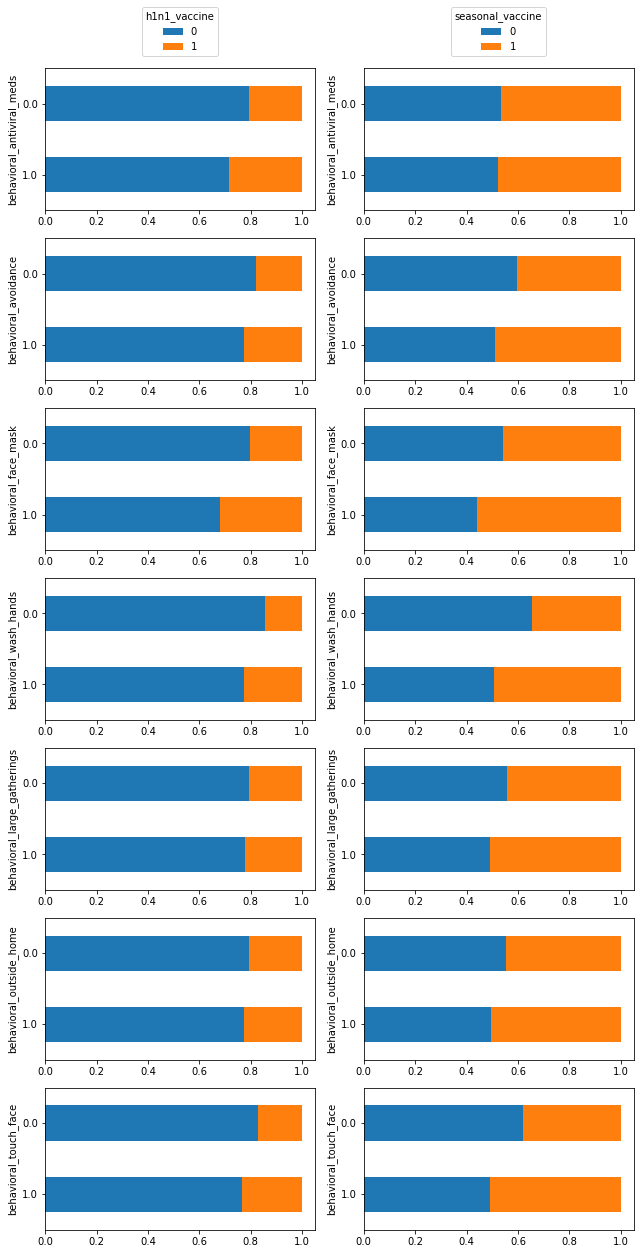

In [14]:
# Features - Preventive measures 
preventive=["behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask", "behavioral_wash_hands",
           'behavioral_large_gatherings', "behavioral_outside_home","behavioral_touch_face" ]

cols_to_plot=preventive

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout();

# No difference in preventive behaviors between vaccinated and non-vaccinated

# vaccinated => more masks and more hand-wash 


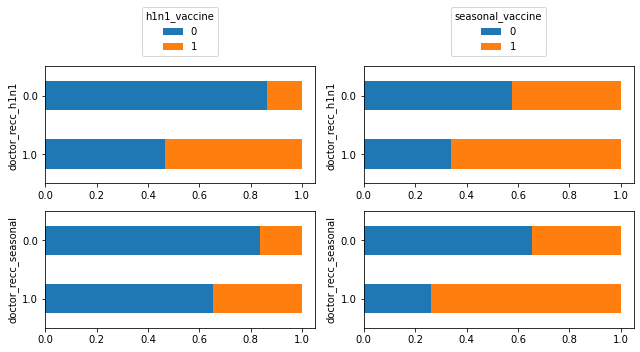

In [15]:
# Features - Doctor recommendations 
recc=["doctor_recc_h1n1","doctor_recc_seasonal" ]

cols_to_plot=recc

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

# People who received vaccine recommendation by doctors are more likely to be vaccinated.  
# But, people who recieved doctors' recommendation might be a high risk group of people,  
# or people who constantly visit hopitals. 


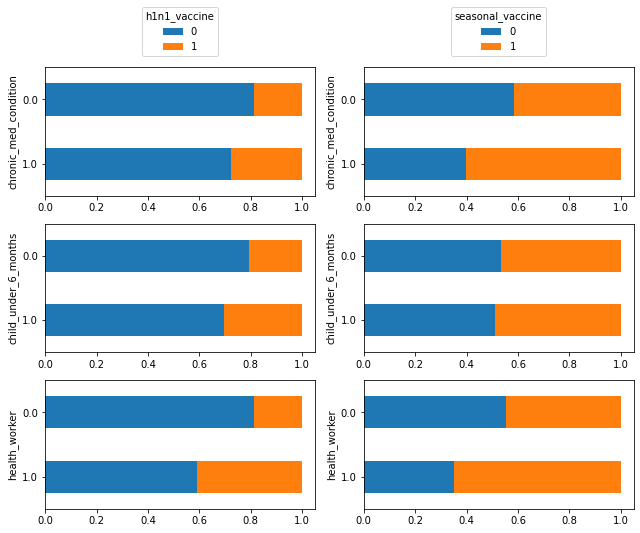

In [16]:
# Features - High Risk 

highrisk=["chronic_med_condition", 'child_under_6_months', 'health_worker']


cols_to_plot=highrisk

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout(); 

# Peopel who has chronic medical conditions are more likely to get vaccinated (both). 
# Health workers are more likely to get vaccinated (both)
# People live with infant are more likely to get vaccinated (H1N1)

# High risk group received more shots . 


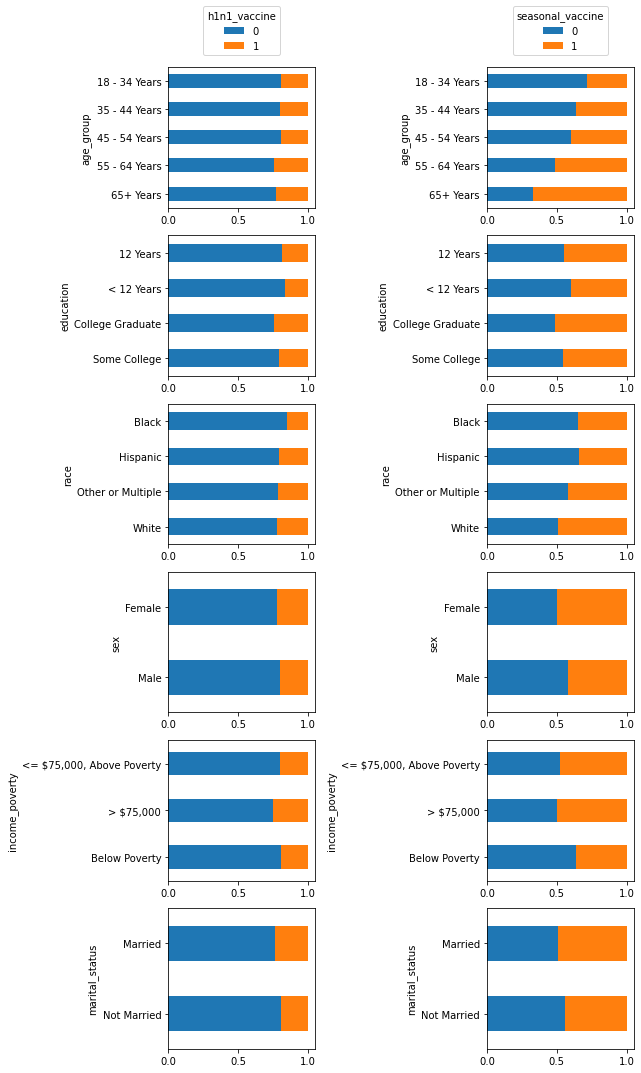

In [17]:
# Features - Socioeconomics
socioeconomic_1=["age_group", 'education', 'race', 'sex', 'income_poverty', 
                 'marital_status']

cols_to_plot=socioeconomic_1

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout(); 

# Age group: Older => more seasonal flue shots 
# Education: Collage grads => slightly higher vaccination rate
# Race: Black/Hispanic => slightly lower vaccination rate
# Sex: Female => slightly higher (seasonal flu)
# Income: below poverty => slightly lower
# Marital: married => slightly higher

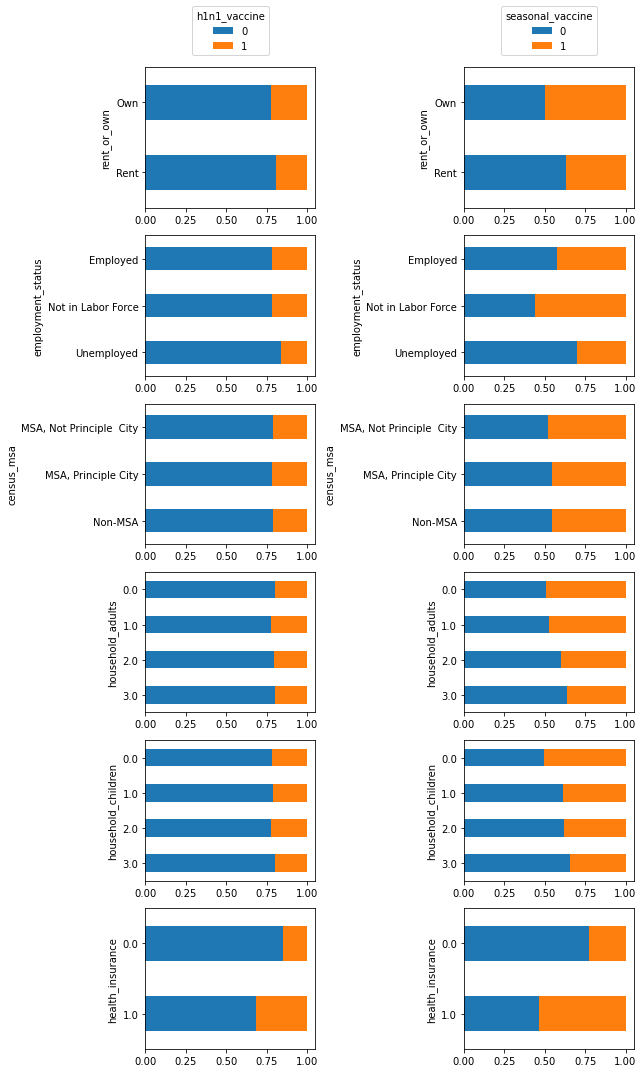

In [18]:
# Features - Socioeconomics 2
socioeconomic_2=['rent_or_own', 'employment_status', 'census_msa', 
               'household_adults', 'household_children', 'health_insurance']

cols_to_plot=socioeconomic_2

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout(); 

# Rent: Renter => lower (especially seasonal flu)
# Employment status: Unemployed => lower
# MSA: Do difference between urban/rural 
# household_adult: single adult => higher vaccination (seasonal flu)
# household_children: zero => higher vaccination 
# health insurance: yes => higher vaccination (both)

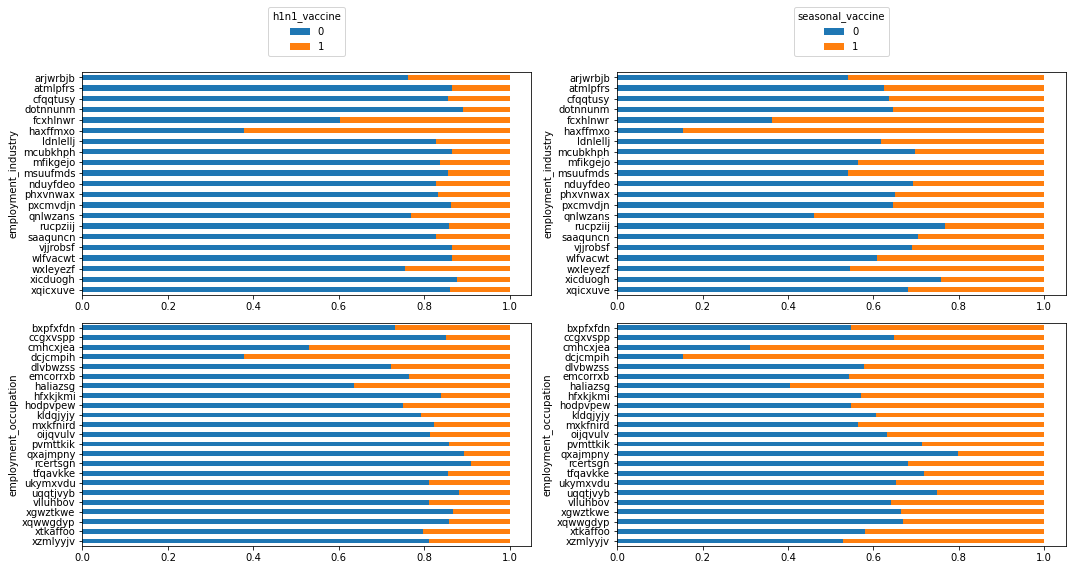

In [19]:
# Features - Industry codes and occupation codes 
socioeconomic_3=['employment_industry', 
               'employment_occupation']

cols_to_plot=socioeconomic_3

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(15,len(cols_to_plot)*4)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout(); 